In [10]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import os
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


In [11]:
ds_version = "weseraue"
# annotations_file = "streetSurfaceVis_v1_0.csv"
# pred_file = "effnet_surface_quality_prediction-V1_0_s_1024-20240612_111928.csv"
root_data_path = os.path.join("..", "data", ds_version)
# root_data_path = f"/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/{ds_version}"
data_path = os.path.join(root_data_path, "prediction")
# only_validation = True
confidence_threshold = 0.9

saving_name = "blur_weseraue_no_blur_results.csv"

In [12]:
def compute_measures_cat(true, pred):
    return{
        "accuracy": sum(true == pred) / len(true)
    }

def compute_measures_float(true_float, pred_float):
    m = {
    "accuracy": sum(true_float.round() == pred_float.round()) / len(true_float),
    "correlation": np.corrcoef(true_float, pred_float)[0, 1],
    "r_square": r2_score(true_float, pred_float),
    "mse": mean_squared_error(true_float, pred_float)
    }
    m["rmse"] = np.sqrt(m["mse"])
    return m

In [13]:
# annot = pd.read_csv(os.path.join(root_data_path, annotations_file))
# annot.rename(columns={"mapillary_image_id": "image_id", "surface_type": "type_true"}, inplace=True)
# annot = annot[(annot.train == True)]

# print(annot)

In [14]:
# df_blur = pd.DataFrame(
#     {"epoch": [6, 7, 10, 9, 13, 15],
#      "lr": [3, 3, 3, 1, 1, 1],
#     },
# )

df_blur = pd.DataFrame(
    {"run": [1, 2, 3, 4, 5, 6],
    },
)

gm_valid = np.zeros((df_blur.shape[0], 1))
gm_valid_high_conf = np.zeros((df_blur.shape[0], 1))

cm_valid = np.zeros((df_blur.shape[0], 5, 5), dtype=int)
cm_valid_high_conf = np.zeros((df_blur.shape[0], 5, 5), dtype=int)

classification = pd.DataFrame()


yticklabels = []
xticklabels = ["weseraue"]

for index_y, row_m in df_blur.iterrows():
    # index_m = df_blur[(df_blur["kernel"]==row_m['kernel']) & (df_blur["sigma"]==row_m['sigma'])]["model_dataset"].values[0]
    # print(index_m)
    # yticklabels.append(f"model_k_{row_m['kernel'] if row_m['kernel'] != 0 else None}_s_{row_m['sigma'] if row_m['sigma'] != 0 else None}")
    run = row_m["run"]
    yticklabels.append(f"model_run_{row_m['run']}")
    
    # kernel = row_d["kernel"] if row_d["kernel"] != 0 else None
    # sigma = row_d["sigma"] if row_d["sigma"] != 0 else None
    name = f"effnet_no_blur_surface_pred_weseraue_run{run}-weseraue_paving_stones-"
    pred_file = ""
    for root, _, fnames in sorted(os.walk(data_path, followlinks=False)):
        for fname in sorted(fnames):
            if name in fname and fname.endswith('.csv'):
                pred_file = os.path.join(root, fname)
                print(pred_file)
    if pred_file == "":
        raise ValueError(f"no prediction file found for run {run}")
    
    pred = pd.DataFrame()

    # print(f"reading {pred_file}")
    pred = pd.read_csv(pred_file)
    pred.rename(columns={"Image": "image_id",  "Level_0": "type_pred"}, inplace=True)

    pred = pred[pred.Level == "type"][["image_id", "Prediction", "type_pred", "is_in_validation"]]
    pred.rename(columns={"Prediction": "class_prob"}, inplace=True)
    idx = pred.groupby("image_id")["class_prob"].idxmax()
    type_pred = pred.loc[idx].reset_index()
    pred = pred[pred["type_pred"] == "paving_stones"]
    
    type_pred["type_true"] = "paving_stones"
    df = type_pred.set_index("image_id")
    df_high_conf = df[df["class_prob"]>confidence_threshold]
    
    gm = compute_measures_cat(df.type_true, df.type_pred)
    gm_valid[index_y] = round(gm['accuracy'], 3)
    gm_high_conf = compute_measures_cat(df_high_conf.type_true, df_high_conf.type_pred)
    gm_valid_high_conf[index_y] = round(gm_high_conf['accuracy'], 3)

    cm = confusion_matrix(df.type_true, df.type_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
    cm_valid[index_y, :, :] = cm
    cm_high_conf = confusion_matrix(df_high_conf.type_true, df_high_conf.type_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
    cm_valid_high_conf[index_y, :, :] = cm_high_conf

    # misclassification
    if (index_y == 0):
        classification["image_id"] = type_pred["image_id"]
        classification["type_true"] = type_pred["type_true"]
        classification.set_index("image_id", inplace=True)
        classification = classification.join(type_pred[["image_id"]].set_index("image_id"), how="left")

    column = f"run_{row_m['run']}"
    type_pred.rename(columns={"type_pred": f"{column}_class", "class_prob": f"{column}_prob"}, inplace=True)
    pred.rename(columns={"class_prob": f"{column}_ps_prob"}, inplace=True)
    classification = classification.join(type_pred[["image_id", f"{column}_class", f"{column}_prob"]].set_index("image_id"), how="left")
    classification = classification.join(pred[["image_id", f"{column}_ps_prob"]].set_index("image_id"), how="left")


../data/weseraue/prediction/effnet_no_blur_surface_pred_weseraue_run1-weseraue_paving_stones-20240705_110253.csv
../data/weseraue/prediction/effnet_no_blur_surface_pred_weseraue_run2-weseraue_paving_stones-20240705_110309.csv
../data/weseraue/prediction/effnet_no_blur_surface_pred_weseraue_run3-weseraue_paving_stones-20240705_110324.csv
../data/weseraue/prediction/effnet_no_blur_surface_pred_weseraue_run4-weseraue_paving_stones-20240705_110340.csv
../data/weseraue/prediction/effnet_no_blur_surface_pred_weseraue_run5-weseraue_paving_stones-20240705_110355.csv
../data/weseraue/prediction/effnet_no_blur_surface_pred_weseraue_run6-weseraue_paving_stones-20240705_110410.csv


In [15]:
class_columns = [col for col in classification.columns if 'class' in col]

classification['paving_stones_count'] = classification[class_columns].apply(lambda row: (row == 'paving_stones').sum(), axis=1)

classification['paving_stones_percentage'] = classification['paving_stones_count'] / len(class_columns) * 100
classification.to_csv(os.path.join(data_path, "analysis", saving_name), index=True)
classification

,type_true,run_1_class,run_1_prob,run_1_ps_prob,run_2_class,run_2_prob,run_2_ps_prob,run_3_class,run_3_prob,run_3_ps_prob,...,run_4_prob,run_4_ps_prob,run_5_class,run_5_prob,run_5_ps_prob,run_6_class,run_6_prob,run_6_ps_prob,paving_stones_count,paving_stones_percentage
image_id,,,,,,,,,,,,,,,,,,,,,
1003421317011254_1,paving_stones,asphalt,0.999385,0.000329,asphalt,0.988437,0.003238,asphalt,0.974750,0.002031,...,0.982230,0.001040,asphalt,0.998085,0.000605,asphalt,0.999868,1.021803e-04,0,0.000000
1004648970243129_1,paving_stones,asphalt,0.974272,0.012392,asphalt,0.773799,0.020701,asphalt,0.941027,0.013331,...,0.948523,0.012407,asphalt,0.796649,0.090790,asphalt,0.987637,5.719655e-03,0,0.000000
1005094273511271_1,paving_stones,asphalt,0.934678,0.024524,asphalt,0.526163,0.004508,asphalt,0.598663,0.022394,...,0.503607,0.023558,paving_stones,0.513006,0.513006,asphalt,0.734884,5.674034e-02,1,16.666667
1006890656687898_1,paving_stones,paving_stones,0.999653,0.999653,paving_stones,0.998651,0.998651,paving_stones,0.997544,0.997544,...,0.997200,0.997200,paving_stones,0.996100,0.996100,paving_stones,0.999676,9.996763e-01,6,100.000000
1007165086631803_1,paving_stones,asphalt,0.604044,0.013162,unpaved,0.979593,0.001284,unpaved,0.835239,0.002209,...,0.800491,0.003664,unpaved,0.606888,0.015215,unpaved,0.879461,1.328629e-03,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990912734900915_1,paving_stones,asphalt,0.977193,0.008431,asphalt,0.974208,0.001966,asphalt,0.966269,0.004694,...,0.960293,0.005776,asphalt,0.941439,0.024966,asphalt,0.977410,9.049994e-03,0,0.000000
992057481461356_1,paving_stones,asphalt,0.955279,0.043499,asphalt,0.665670,0.194743,asphalt,0.667425,0.192403,...,0.594247,0.235538,paving_stones,0.883470,0.883470,asphalt,0.983372,1.610465e-02,1,16.666667
994533647929913_1,paving_stones,asphalt,0.919079,0.041716,sett,0.533325,0.248090,asphalt,0.689756,0.075287,...,0.714417,0.062376,asphalt,0.863447,0.062471,asphalt,0.902722,7.214785e-02,0,0.000000


In [16]:
count_frequencies = classification['paving_stones_count'].value_counts().sort_index()
normalized_frequencies = count_frequencies / count_frequencies.sum()
# print("Häufigkeit der verschiedenen Count-Werte:")
# print(count_frequencies)
# print(normalized_frequencies)

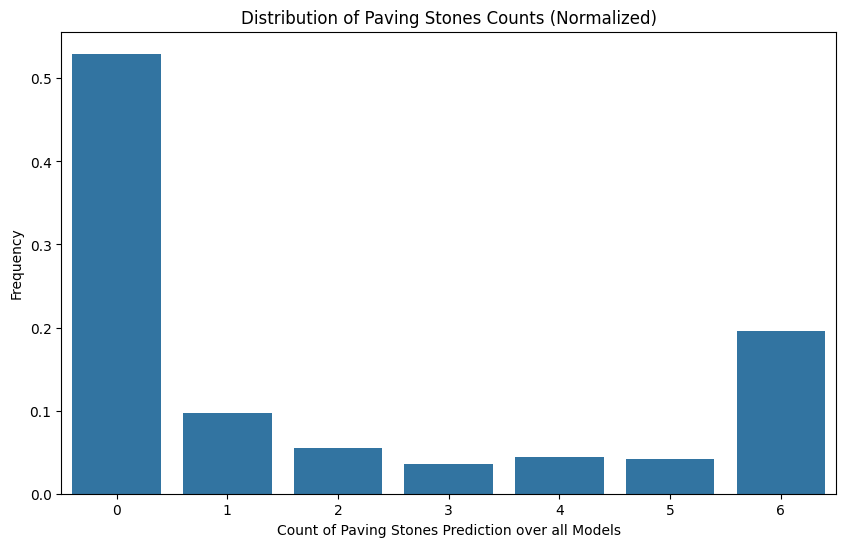

In [17]:
plt.figure(figsize=(10, 6))
# sns.histplot(classification['paving_stones_count'], bins=len(class_columns)+1, kde=True, stat="density")
sns.barplot(x=normalized_frequencies.index, y=normalized_frequencies.values)
plt.title('Distribution of Paving Stones Counts (Normalized)')
plt.xlabel('Count of Paving Stones Prediction over all Models')
plt.ylabel('Frequency')
plt.xticks(range(0, len(class_columns)+1))
plt.show()

In [18]:
gm_valid.shape

(6, 1)

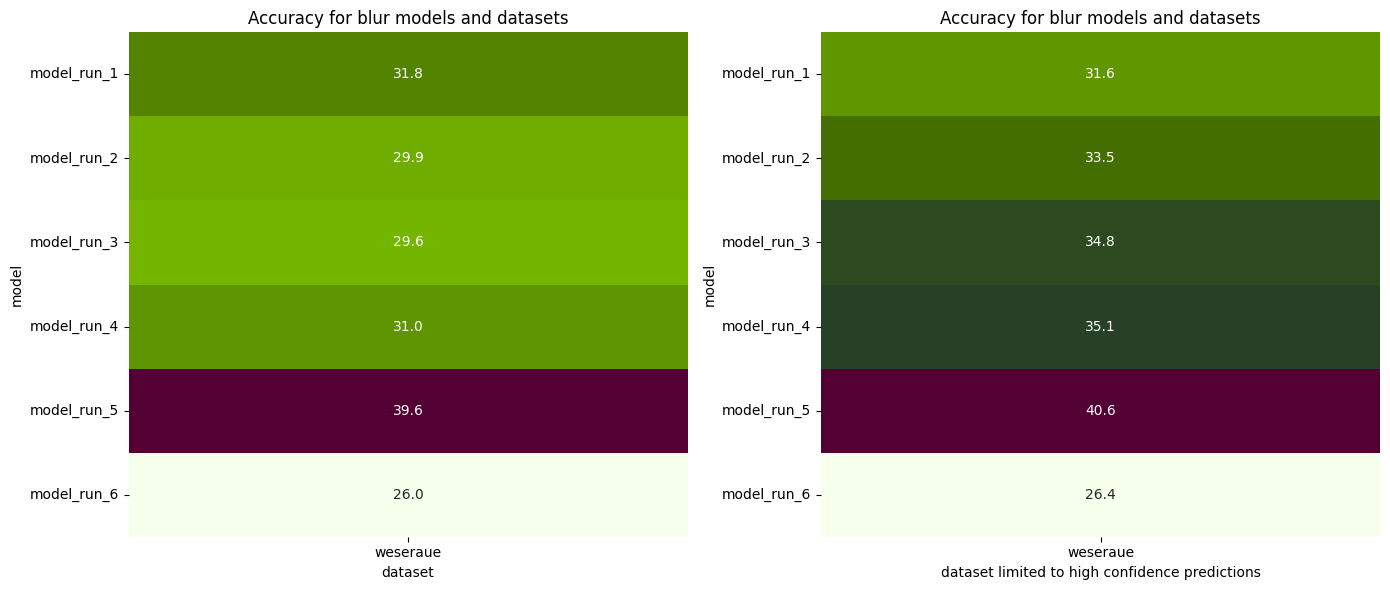

In [19]:
cmap = LinearSegmentedColormap.from_list("mycmap", ["#F7FFED", "#76B900", "#456D00", "#000B53", "#530035"])

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(gm_valid*100, annot=True, fmt=".1f", cmap=cmap, cbar=False,
            xticklabels=xticklabels,
            yticklabels=yticklabels,
            ax=ax[0])
ax[0].set_title(f"Accuracy for blur models and datasets")
ax[0].set_xlabel("dataset")
ax[0].set_ylabel("model")
sns.heatmap(gm_valid_high_conf*100, annot=True, fmt=".1f", cmap=cmap, cbar=False,
            xticklabels=xticklabels,
            yticklabels=yticklabels,
            ax=ax[1])
ax[1].set_title(f"Accuracy for blur models and datasets")
ax[1].set_xlabel("dataset limited to high confidence predictions")
ax[1].set_ylabel("model")
# plt.savefig("blur_v1_0.png", transparent=True, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Confusion Matrix

In [20]:
def plot_conf_matrix(cm, model, dataset):
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"],
                yticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
    plt.title(f"Confusion Matrix for model {model} and dataset {dataset}")
    plt.xlabel("Predicted")
    plt.ylabel("Annotated")
    plt.show()

In [21]:
def plot_conf_matrix_2(cm_1, cm_2, model, dataset):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap(cm_1, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"],
                yticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"],
                ax=ax[0])
    ax[0].set_title(f"Confusion Matrix for model {model} and dataset {dataset}")
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("Annotated")
    sns.heatmap(cm_2, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"],
                yticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"],
                ax=ax[1])
    ax[1].set_title(f"Confusion Matrix for model {model} and dataset {dataset}")
    ax[1].set_xlabel(f"Predicted with probability > {confidence_threshold}")
    ax[1].set_ylabel("Annotated")
    plt.tight_layout()
    plt.show()

In [22]:
def plot_prob_hist(col1, col2, model, dataset):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    sns.histplot(col1, stat="density", ax=ax[0])
    ax[0].set_title(f"Histogram of paving stones probabilities for model {model} and dataset {dataset}")
    ax[0].set_xlabel("Probability of class paving_stones")
    ax[0].set_ylabel("Density")
    sns.histplot(col2, stat="density", ax=ax[1])
    ax[1].set_title(f"Histogram of predicted class probabilities for model {model} and dataset {dataset}")
    ax[1].set_xlabel("Probability of predicted class")
    ax[1].set_ylabel("Density")
    plt.tight_layout()
    plt.show()

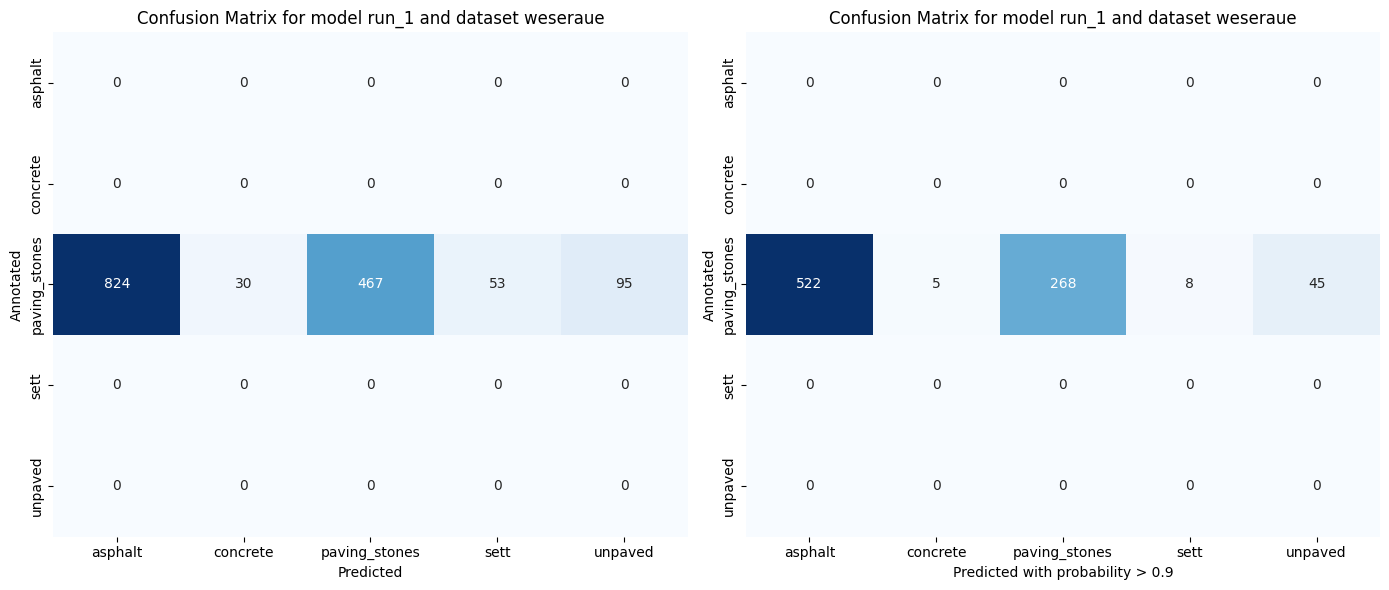

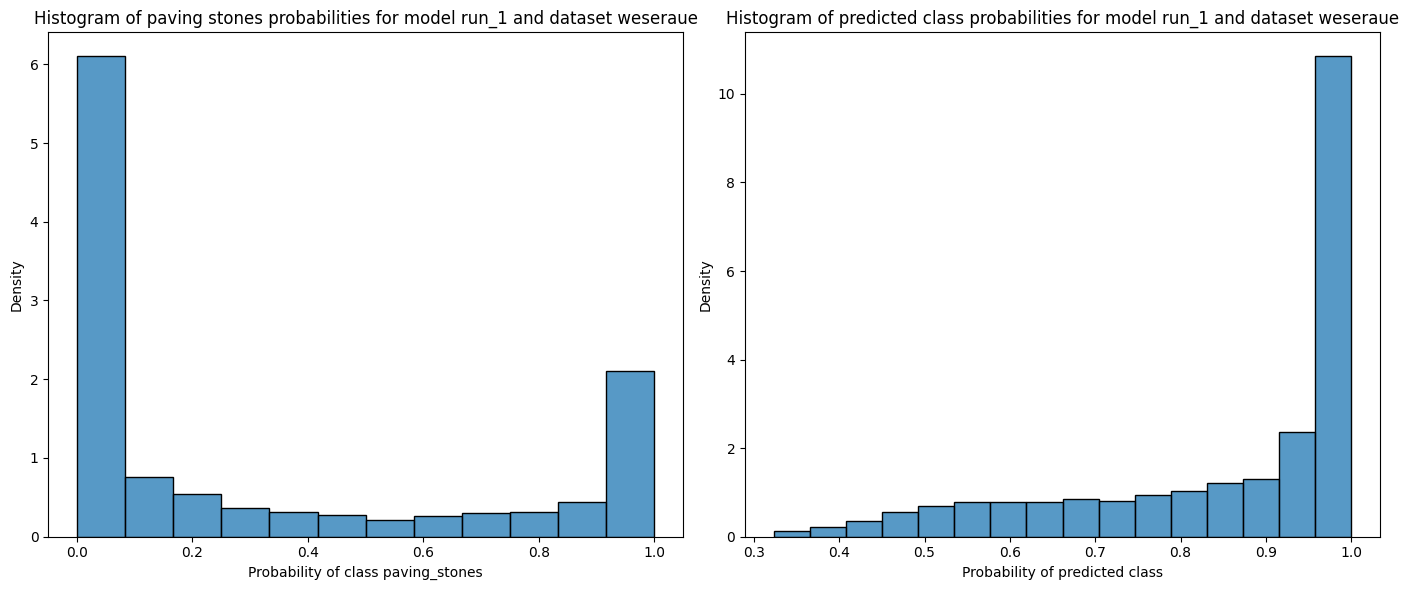

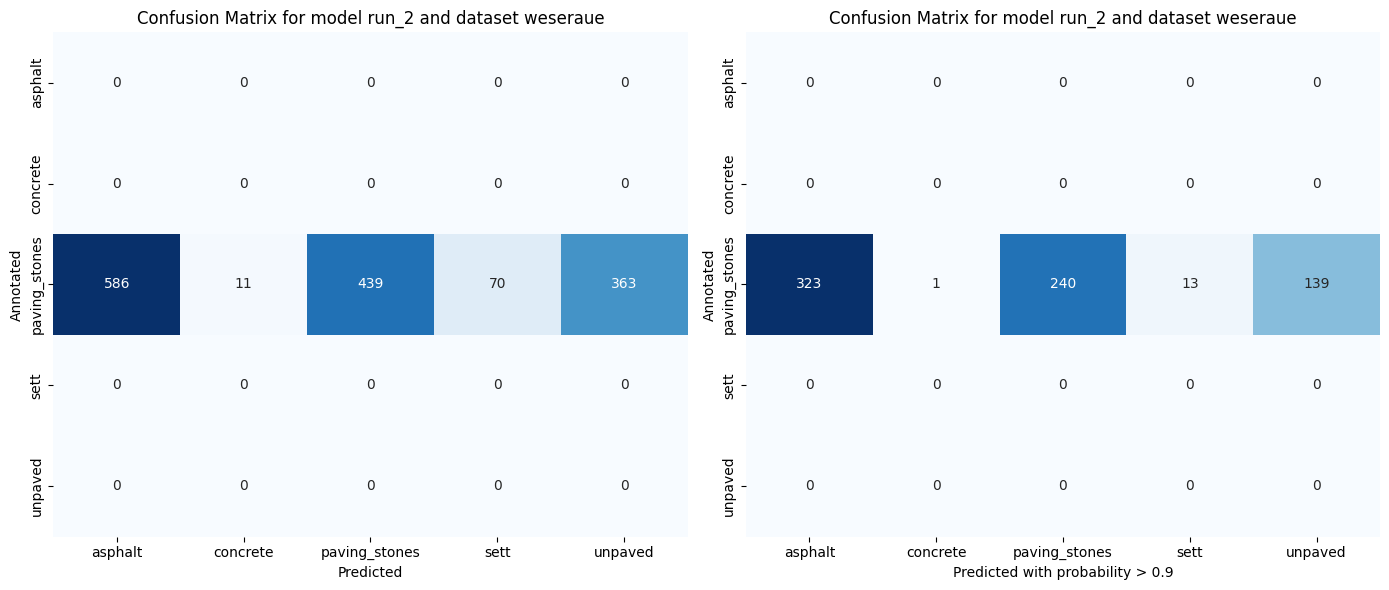

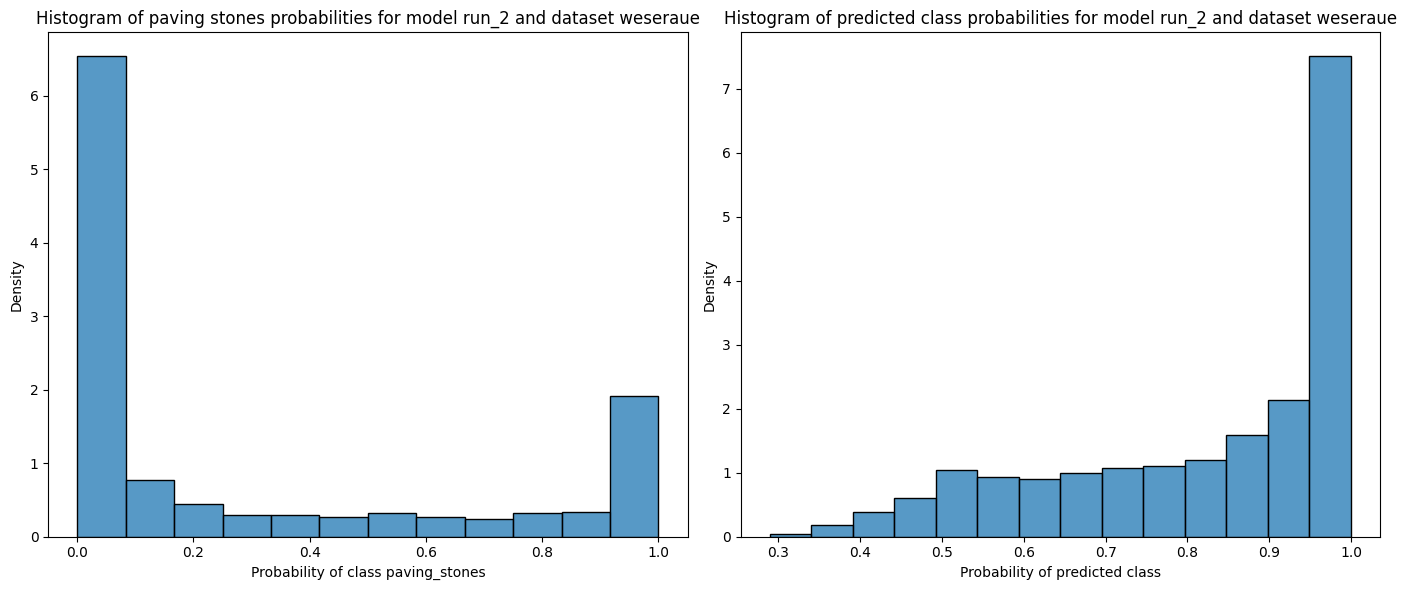

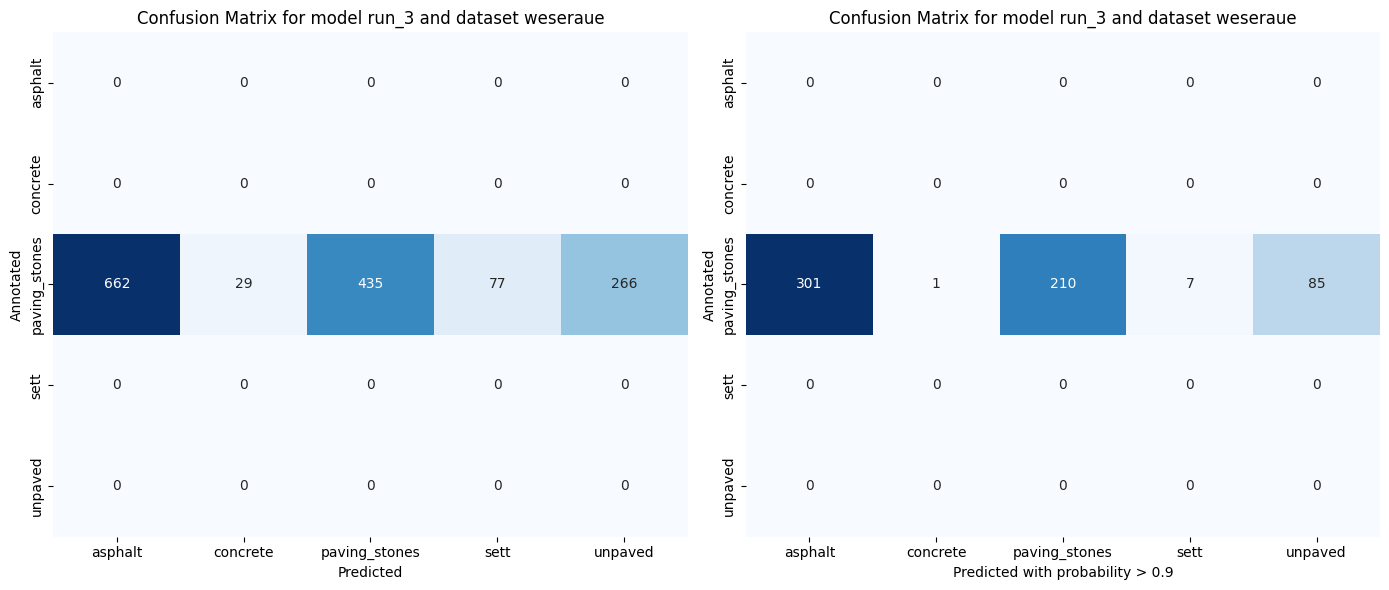

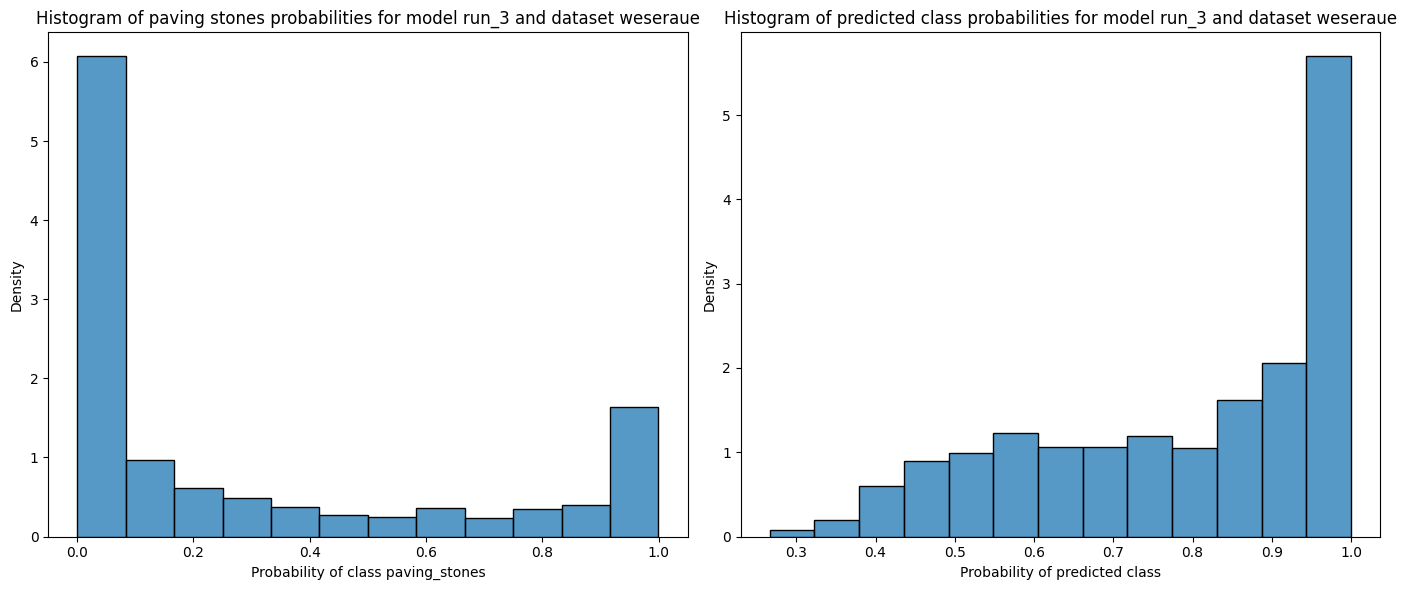

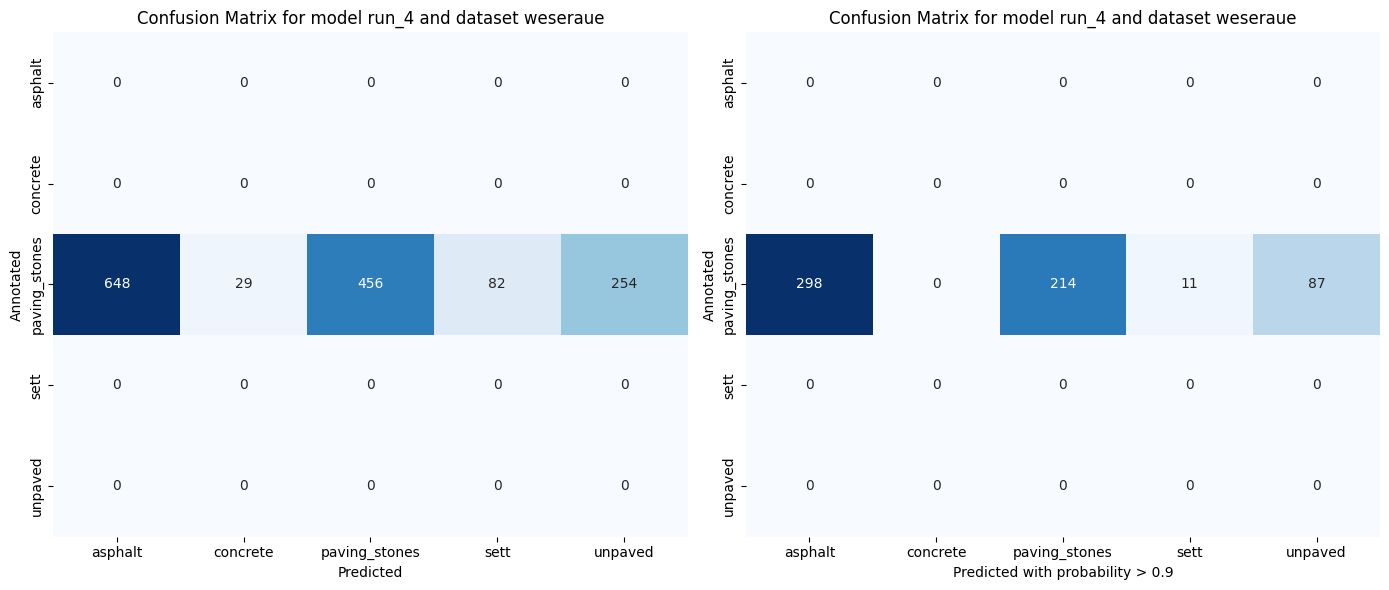

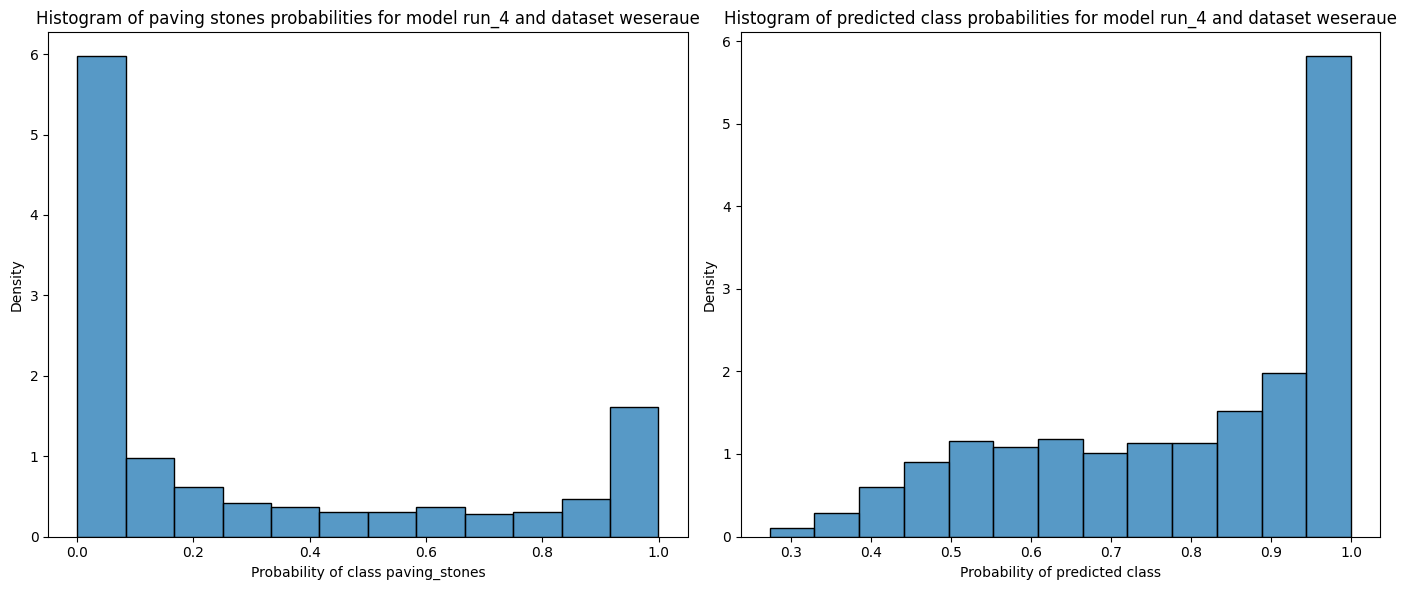

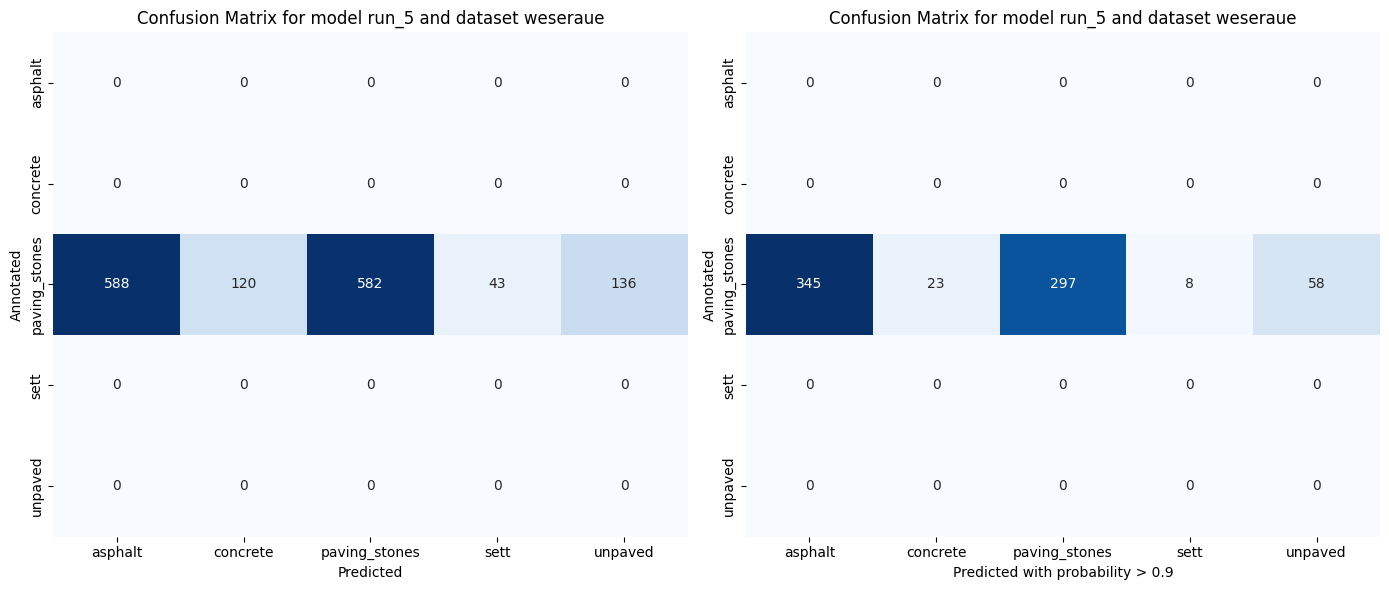

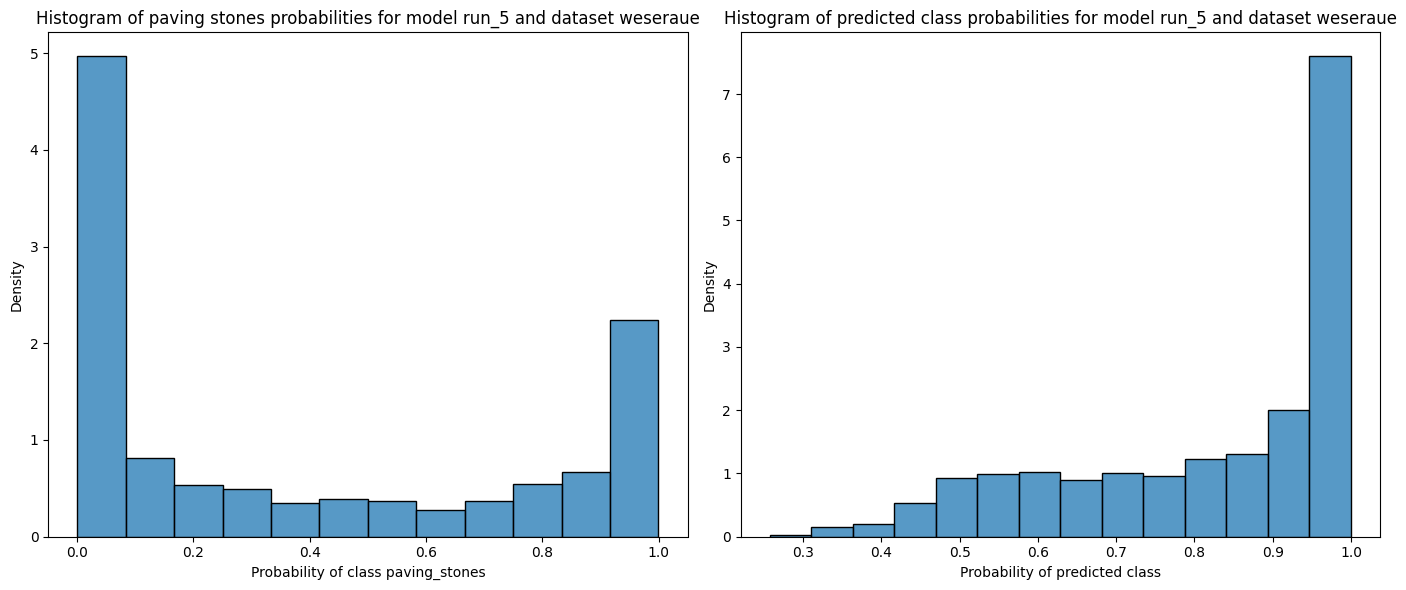

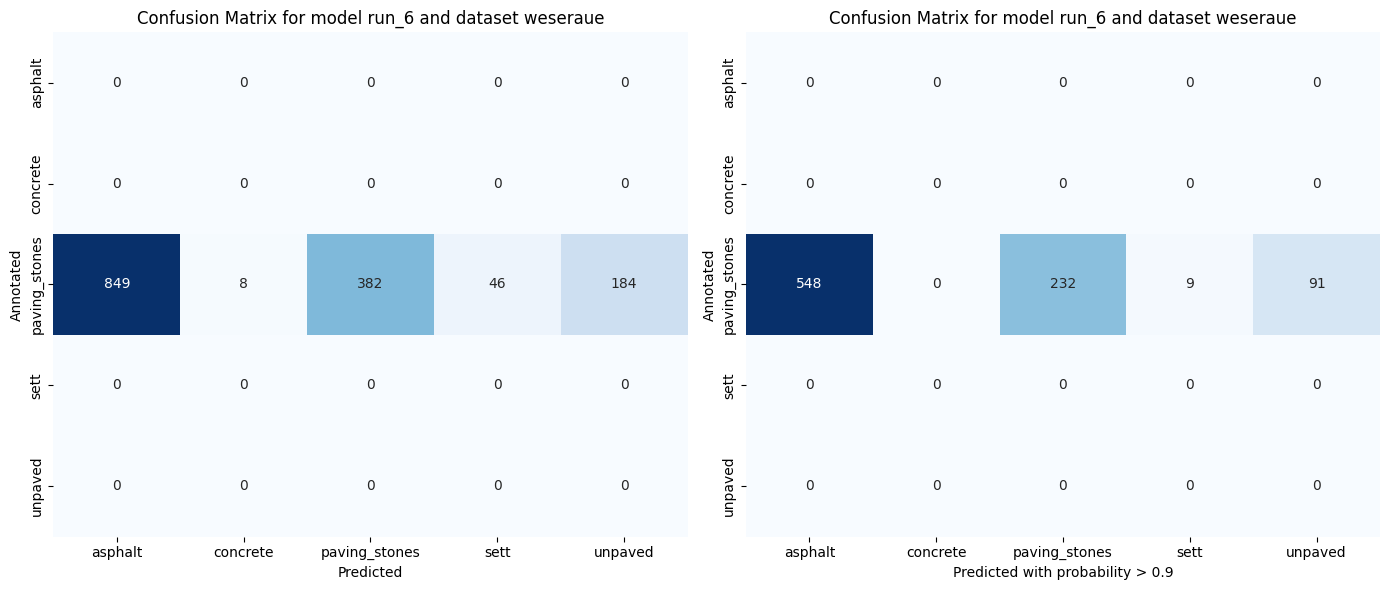

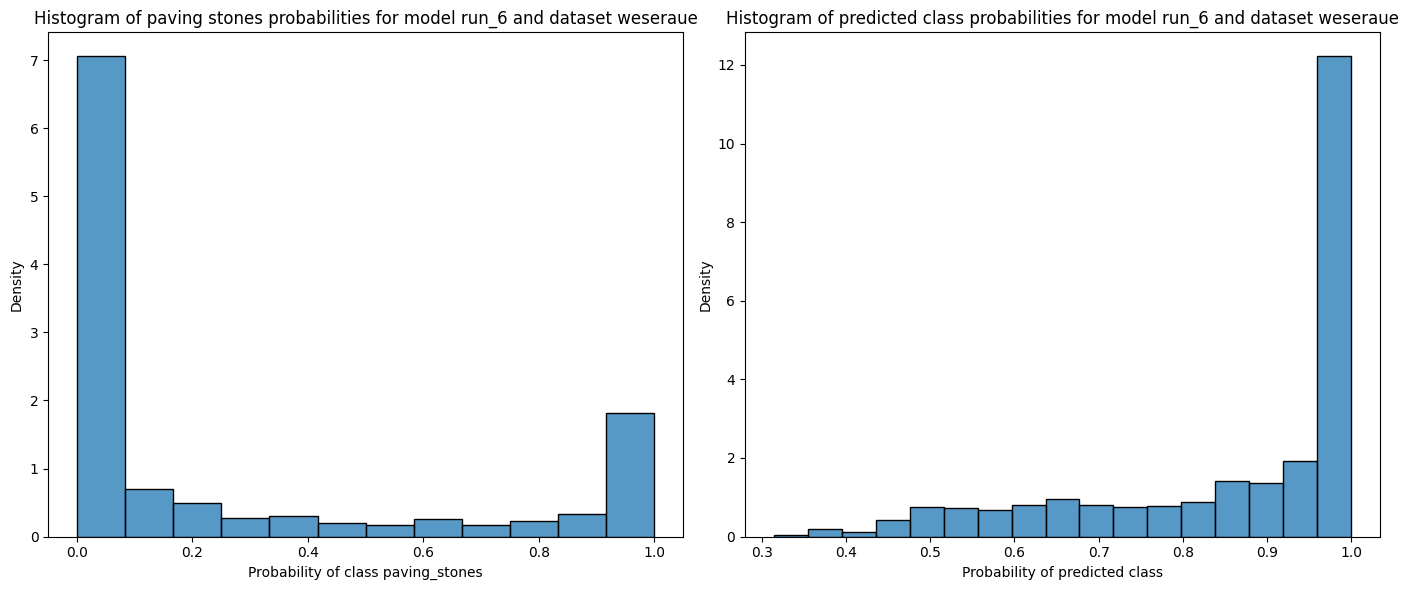

In [23]:
# k_5 s_2 & k_11 s_5

for index_y, model_row in df_blur.iterrows():

        plot_conf_matrix_2(cm_valid[index_y, :, :], cm_valid_high_conf[index_y, :, :], f"run_{model_row['run']}", "weseraue")

        column = f"run_{model_row['run']}"

        plot_prob_hist(classification[f"{column}_ps_prob"], classification[f"{column}_prob"], f"run_{model_row['run']}", "weseraue")

# Misclassified

In [ ]:
# # all images that were incorrectly classified
# misclassification = df[(df.surface_label_pred != df.surface_true) & (df.is_in_validation == 1)]

# misclassification = misclassification.sort_values("image_id")
# misclassification.reset_index( inplace=True)
# misclassification[["image_id", "is_in_validation", 
#                    "surface_true", "surface_label_pred", "quality_label_true"]
#                    ].to_csv(os.path.join(data_path, "model_predictions", "misclassification_surface.csv"), index=False)